In [25]:
import ast
import os

%matplotlib inline
from zipfile import ZipFile

import numpy as np
import pandas as pd
import requests
import resqpy
import xtgeo
from fmu.sumo.explorer import Explorer
from resqpy.crs import Crs
from resqpy.model import Model, new_model
from resqpy.surface import Mesh

## Ensemble 

Uuid and filter specifications of the case we want to extract and convert realizations from

In [26]:
uuid = "06e53a20-3384-4c0e-a9cc-202bebedf7c4"

iterations = "iter-0"
tagnames = "DS_extract_geogrid" + ";" + "apstrend_aps_crevasse_Average"

# Names are optional, leave blank if include all names
names = ""

Also need an auth token attached to the header

In [27]:
token = Explorer("dev")._sumo.auth.get_token()

header = {"Authorization": "Bearer " + token}

Then send the post request

In [28]:
body = {"uuid": uuid, "iter": iterations, "tags": tagnames, "name": names}

response = requests.post(
    "https://api-fmu-to-resqml-dev.playground.radix.equinor.com/ensemble/",
    data=body,
    headers=header,
)

And store the response in a zip

In [29]:
with open("response_ensemble.zip", "wb") as f:
    f.write(response.content)

## Single Object

Decide the UUID of the object we want converted into RESQML and downloaded

In [30]:
# In this case, we chose a surface
uuid = "b42dba1a-8012-fe89-3e1f-a098a0b7a230"

Also need an auth token attached to the header

In [31]:
token = Explorer("dev")._sumo.auth.get_token()

header = {"Authorization": "Bearer " + token}

Interact with the API and extract both EPC and HDF files of the given object

In [32]:
response = requests.get(
    f"https://api-fmu-to-resqml-dev.playground.radix.equinor.com/objects/?uuid={uuid}",
    headers=header,
)

Read and store response into a zip directory saved on disk

In [33]:
with open("response_object.zip", "wb") as f:
    f.write(response.content)

Unzip and inspect the files given

In [34]:
# Unzip files into "temp" directory
with ZipFile("response_object.zip", "r") as zip:
    zip.extract("epc.zip", "temp/")
    zip.extract("hdf.zip", "temp/")

with ZipFile("temp/epc.zip", "r") as zip:
    zip.extractall("temp/")
os.remove("temp/epc.zip")

with ZipFile("temp/hdf.zip", "r") as zip:
    zip.extractall("temp/")
os.remove("temp/hdf.zip")

# Rename all files from uuid to "temp"
for file in os.listdir("temp"):
    ext = file.split(".")[-1]
    os.rename("temp/" + file, "temp/temp." + ext)

# Create RESQPY model from data
model = Model("temp/temp.epc")

Try to inspect the model

In [35]:
model.parts()

['obj_LocalDepth3dCrs_b0526cc4-1c97-11ee-930c-5a7cd4ff81d3.xml',
 'obj_Grid2dRepresentation_b08d5884-1c97-11ee-930c-5a7cd4ff81d3.xml']

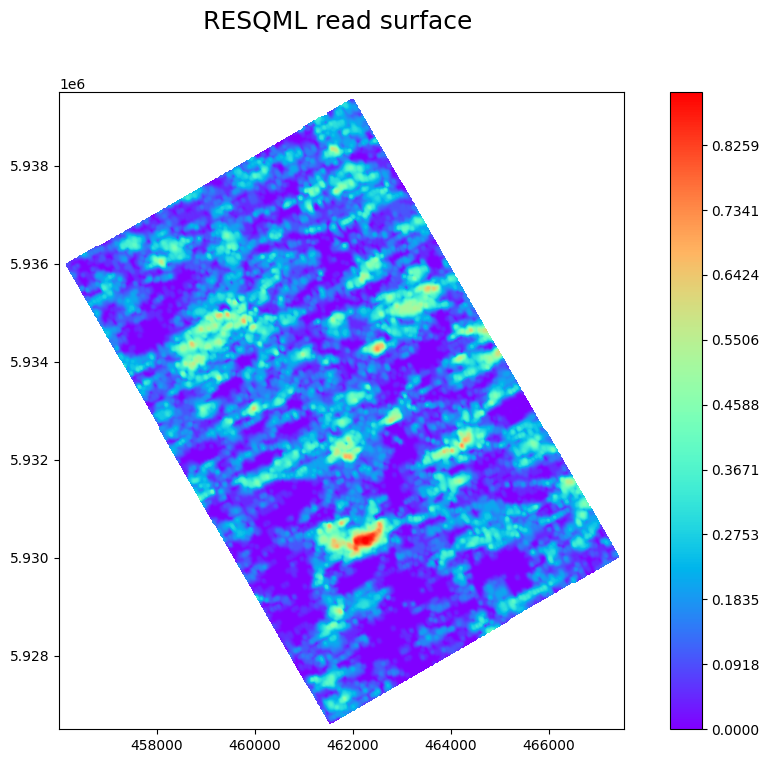

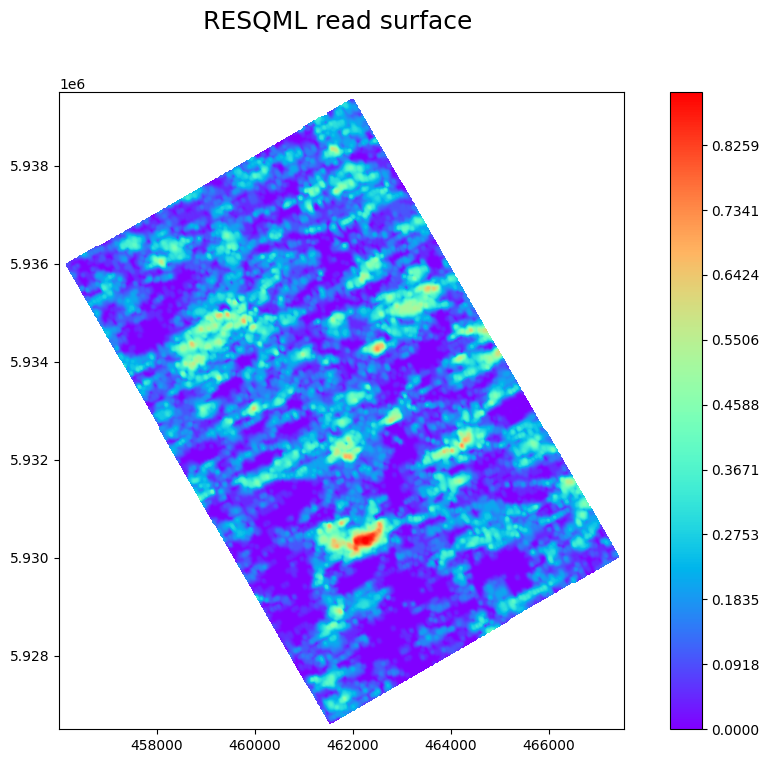

In [36]:
crs_uuid = model.uuid(obj_type="obj_LocalDepth3dCrs")
crs = Crs(model, uuid=crs_uuid)
mesh_uuid = model.uuid(obj_type="obj_Grid2dRepresentation")
mesh = Mesh(model, uuid=mesh_uuid)

ncol = mesh.nj
nrow = mesh.ni
xinc = mesh.regular_dxyz_dij[0, 0]
yinc = mesh.regular_dxyz_dij[1, 1]
xori = crs.x_offset
yori = crs.y_offset
yflip = 1 if crs.z_inc_down else -1
rotation = crs.rotation
values = mesh.full_array_ref()[:, :, 2]

undef_value = ast.literal_eval(mesh.extra_metadata["data"])["spec"]["undef"]

masked_array = np.ma.masked_values(values, undef_value)

surf = xtgeo.RegularSurface(
    ncol=ncol,
    nrow=nrow,
    xinc=xinc,
    yinc=yinc,
    xori=xori,
    yori=yori,
    yflip=yflip,
    rotation=rotation,
    values=masked_array,
)
surf.quickplot(title="RESQML read surface")

In [37]:
# At last, remove all temporary files
os.remove("temp/temp.epc")
os.remove("temp/temp.h5")
os.rmdir("temp")